## Mini Project 5: Unsupervised Learning (Customer Segmentation/Clustering)

# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [ ]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import os
# os.chdir('/content/drive/MyDrive/Gcolab/Unsupervised Learning/Clustering')

In [ ]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# # Load data
# df = pd.read_csv('OnlineRetail.csv', encoding='latin-1')
# df.head()

In [ ]:
df_answer = df.copy()

Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [ ]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [ ]:
# Remove missing value
df = df[df["CustomerID"].notna()]

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Then we could do some descriptive statistic.

In [ ]:
df.shape

(406829, 8)

In [ ]:
# Simple descriptive statistic
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [ ]:
# Check anomaly data (Ada berapa data yg kurang dari 0 untuk quantity dan sama dengan 0 untuk price)
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


Then just remove those anomaly/Outliers data

In [ ]:
# Remove anomaly / outliers
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we're good to go. Lets do some data exploration!

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


The data contains 397884 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

In [ ]:
# Check unique value
df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].nunique()

InvoiceNo     18532
StockCode      3665
CustomerID     4338
Country          37
dtype: int64

There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

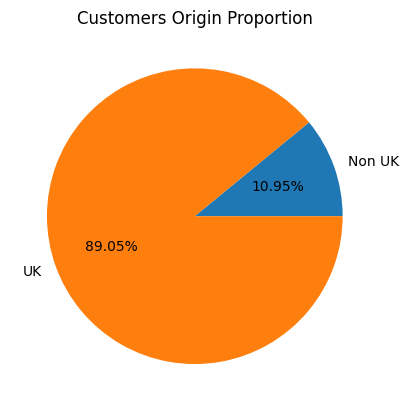

In [ ]:
# Simplify country origin (Pie chart untuk melihat komposisi negara)
df['Country_isUK'] = np.where(df['Country']=='United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [ ]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


Then plot the trendline.

In [ ]:
import matplotlib.dates as mdates

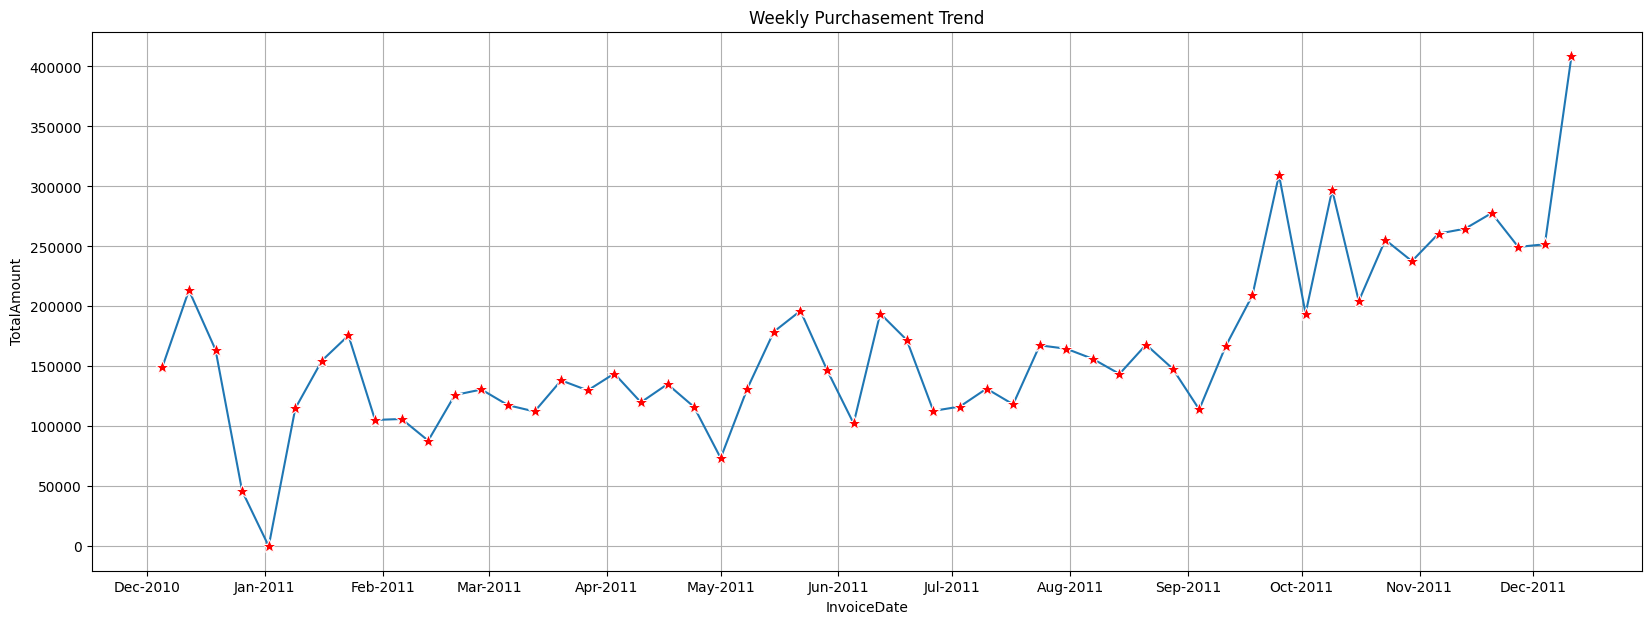

In [ ]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

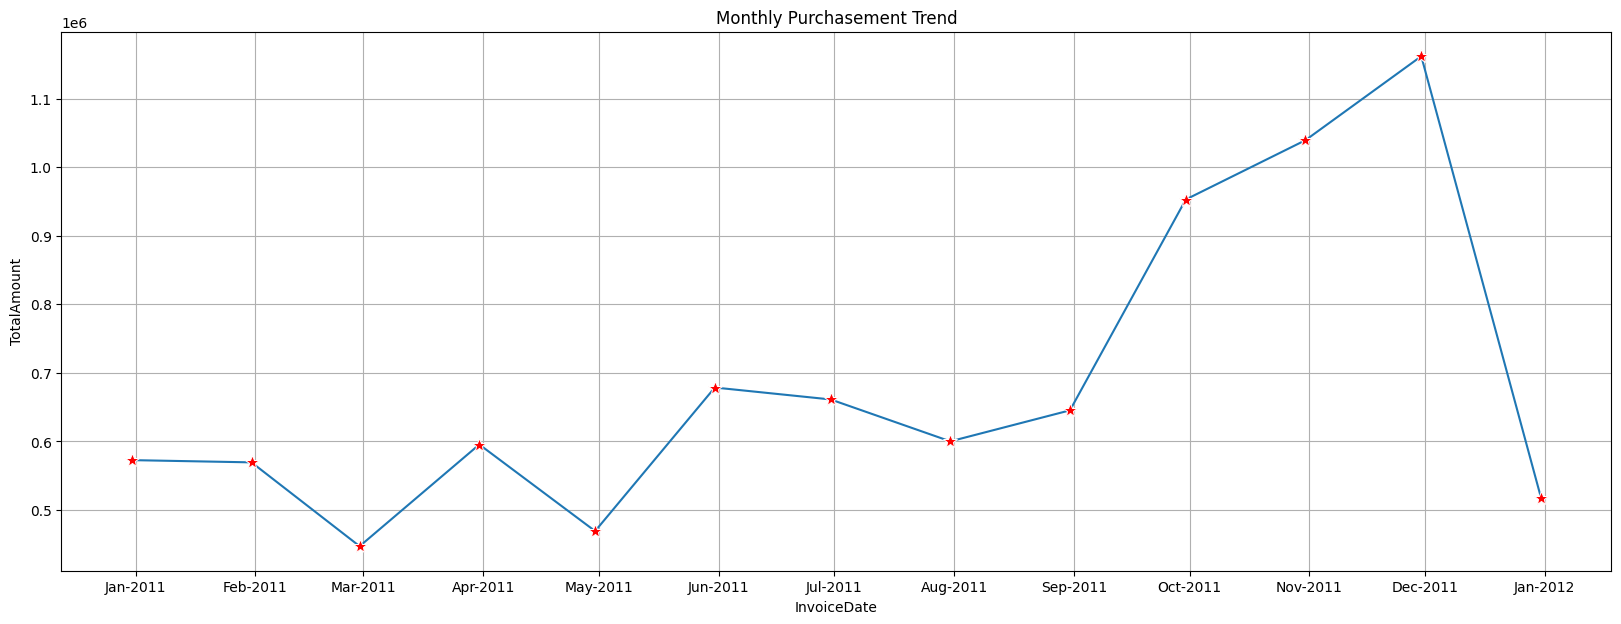

In [ ]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [ ]:
# Get customer's recency
recency =  df.groupby(['CustomerID'])['InvoiceDate'].max()
recency = max(recency) - recency
recency = recency.dt.days
recency = recency.rename('Recency')

recency.head()

CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
Name: Recency, dtype: int64

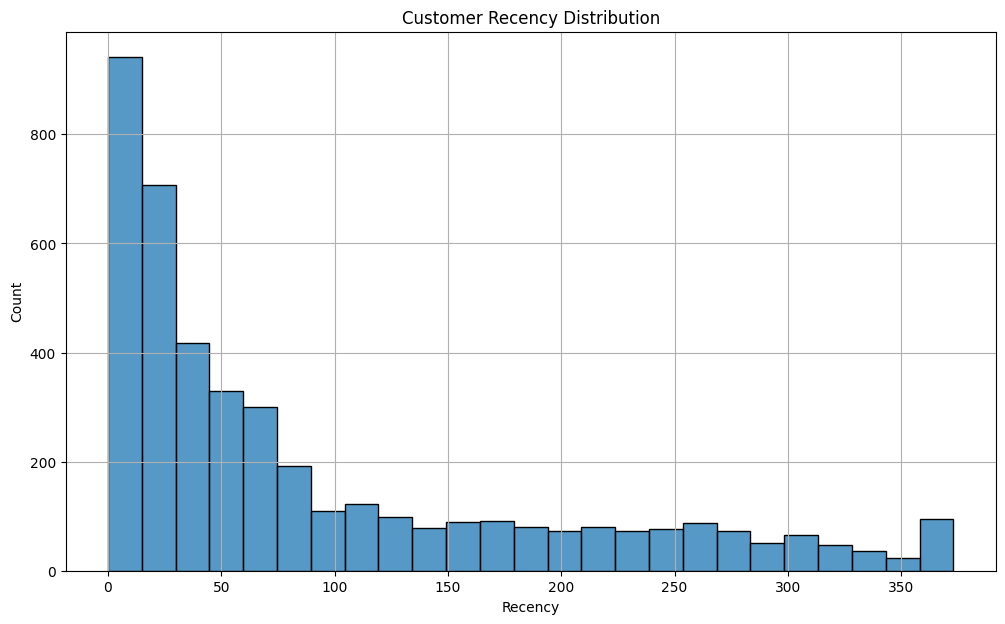

In [ ]:
# Recency histogram plot
plt.figure(figsize=(12, 7))
sns.histplot(recency)
plt.title('Customer Recency Distribution')
plt.grid()
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [ ]:
# Count frequency
frequency = df.groupby(['CustomerID'])['InvoiceNo'].count()
frequency = frequency.rename('Frequency')
frequency.head()

CustomerID
12346.0      1
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: Frequency, dtype: int64

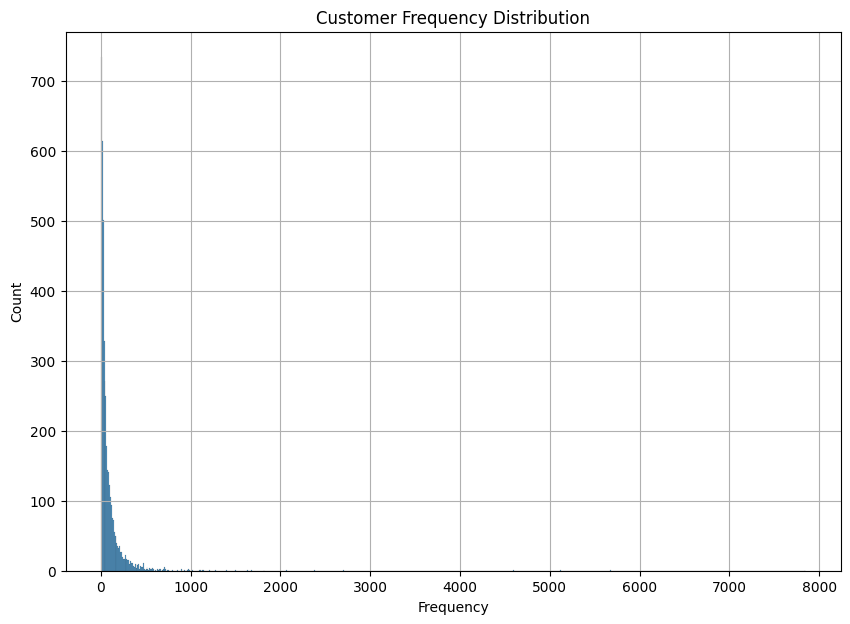

In [ ]:
# Frequency histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Frequency Distribution')
sns.histplot(frequency)
plt.grid()
plt.show();

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [ ]:
# Sum the money spent
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()
monetary = monetary.rename('Monetary Spent')
monetary.head()

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
Name: Monetary Spent, dtype: float64

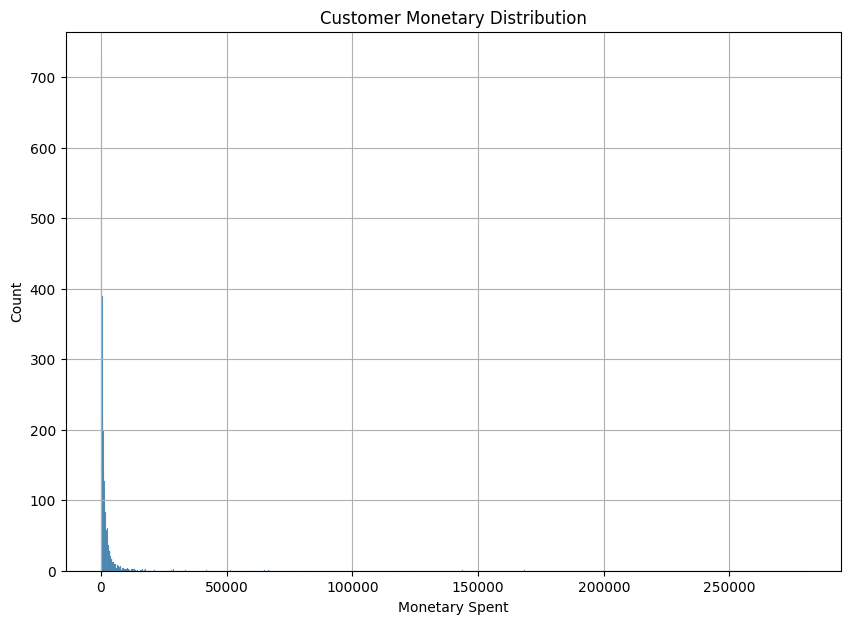

In [ ]:
# Monetary histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Monetary Distribution')
sns.histplot(monetary)
plt.grid()
plt.show()

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [ ]:
# Get customer's country of origin
country = (
    df.groupby(['CustomerID', 'Country_isUK'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)#chaining method

# Merge the data
df_new = (
  country
  .merge(recency, on='CustomerID')
  .merge(frequency, on='CustomerID')
  .merge(monetary, on='CustomerID')
)

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')
df_new.head()

,Country_isUK,Recency,Frequency,Monetary Spent
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [ ]:
# Recode the non numeric variable

df_new = pd.get_dummies(
    df_new,
    columns=['Country_isUK'],
    drop_first=True
)

df_new = df_new.rename(
    columns={'Country_isUK_UK': 'Country_UK'}
)

df_new.head()

,Recency,Frequency,Monetary Spent,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,True
12347.0,1,182,4310.00,False
12348.0,74,31,1797.24,False
12349.0,18,73,1757.55,False
12350.0,309,17,334.40,False


### Scaling

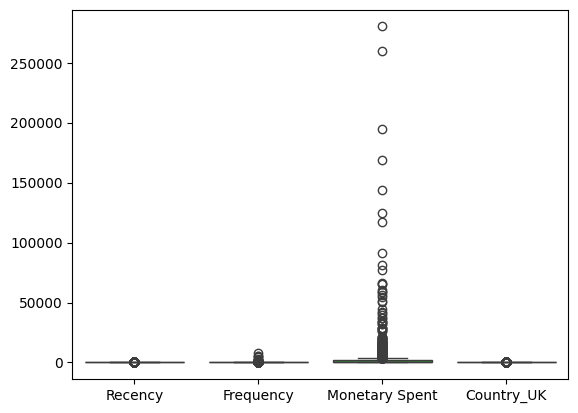

In [ ]:
sns.boxplot(data=df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [ ]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index
)

df_scaled.head()

,Recency,Frequency,Monetary Spent,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


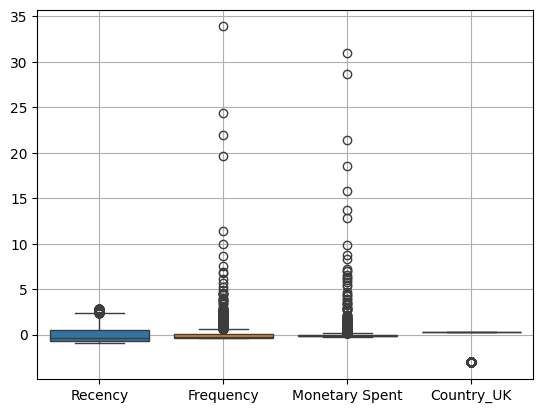

In [ ]:
# Plot scaled data
sns.boxplot(data = df_scaled)
plt.grid()
plt.show()

## Modeling

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    silhouette.append(silhouette_score(X=df_scaled, labels=kmeans.labels_))

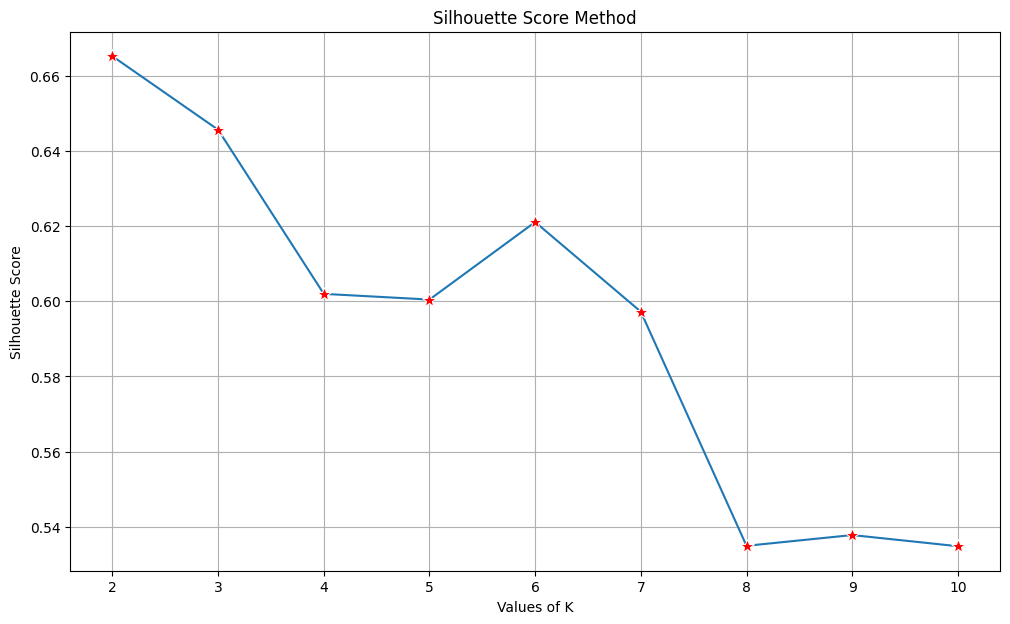

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best K is either 2, 3 or 6

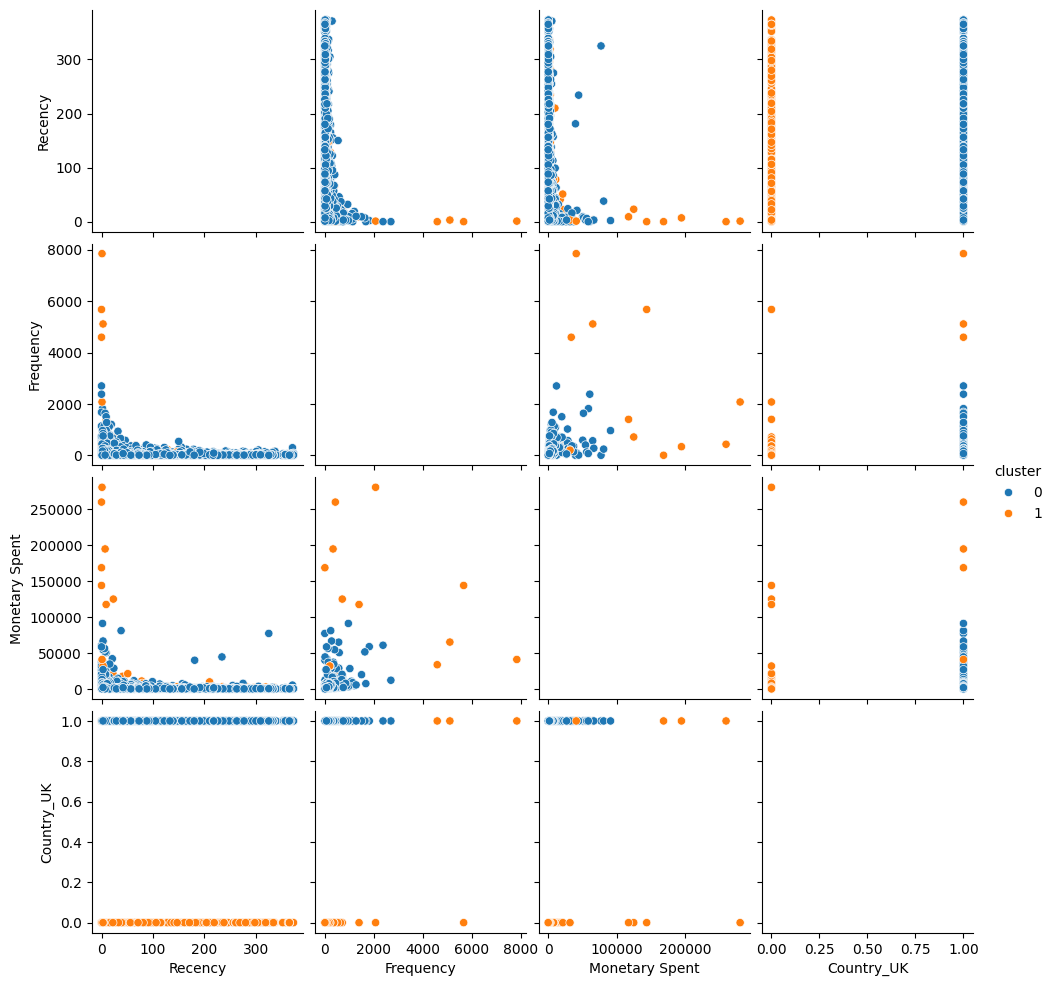

In [ ]:
#Pairplot
kmeans = KMeans(n_clusters=2, random_state=42).fit(df_scaled)
# ganti n_clusters sesuai pilihan terbaik

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                           0              1
Recency        mean       91.349770      93.259434
               std        99.548570     104.320241
               min         0.000000       0.000000
               q25        17.000000      16.750000
               median     50.000000      50.500000
               q75       142.000000     133.000000
               max       373.000000     373.000000
Frequency      mean       85.844916     145.959906
               std       142.976762     586.766018
               min         1.000000       1.000000
               q25        17.000000      22.000000
               median     41.000000      45.000000
               q75        99.000000     105.000000
               max      2700.000000    7847.000000
Monetary Spent mean     1672.415655    5579.181675
               std      4560.815176   24945.491611
               min         3.750000      51.560000
               q25       300.025000     462.967500
               median    650.430000    1040.780000
               q75      1570.030000    2792.320000
               max     91062.380000  280206.020000

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        True          3914
1        False          418
         True             6
Name: Recency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Frequency"].count()

cluster  Country_UK
0        True          3914
1        False          418
         True             6
Name: Frequency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Monetary Spent"].count()

cluster  Country_UK
0        True          3914
1        False          418
         True             6
Name: Monetary Spent, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (30 point) Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?
3. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

#Jawaban Question 1

In [ ]:
#b) nunique.idxmax() --> Pada saat melakukan group by
df_answer.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Remove missing value
df_answer = df_answer[df_answer["CustomerID"].notna()]

df_answer.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
# Remove anomaly / outliers
df_answer = df_answer[(df_answer["Quantity"] > 0) & (df_answer["UnitPrice"] > 0)]

df_answer[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [ ]:
# Create new features and cast date column
df_answer['TotalAmount'] = df_answer['Quantity'] * df_answer['UnitPrice']
df_answer['InvoiceDate'] = pd.to_datetime(df_answer['InvoiceDate'])

df_answer.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


**Pertanyaan**:<br>
a) Siapa top 5 customer dengan pembelian terbanyak? <br>
b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). <br><br>EDA juga bisa dilakukan menggunakan business question lain.

In [ ]:
# a) Top 5 Costumers with max purchases (dengan pivot Table)

df_answer_pivot = pd.pivot_table(data = df_answer,
                                 index=['CustomerID','Country'],
                                 values = 'TotalAmount',
                                 aggfunc='sum').sort_values(by=['TotalAmount'], ascending=False)

df_answer_pivot.head(5)

,,TotalAmount
CustomerID,Country,
14646.0,Netherlands,280206.02
18102.0,United Kingdom,259657.30
17450.0,United Kingdom,194550.79
16446.0,United Kingdom,168472.50
14911.0,EIRE,143825.06


In [ ]:
# Cara Lain dengan groupby
customer_order = df.groupby(["CustomerID","Country"]).agg({"TotalAmount": "sum"}).sort_values(by='TotalAmount', ascending=False)
customer_order.head(5)

,,TotalAmount
CustomerID,Country,
14646.0,Netherlands,280206.02
18102.0,United Kingdom,259657.30
17450.0,United Kingdom,194550.79
16446.0,United Kingdom,168472.50
14911.0,EIRE,143825.06


In [ ]:
top_5_customers = customer_order.nlargest(5, 'TotalAmount')
top_5_customers

,,TotalAmount
CustomerID,Country,
14646.0,Netherlands,280206.02
18102.0,United Kingdom,259657.30
17450.0,United Kingdom,194550.79
16446.0,United Kingdom,168472.50
14911.0,EIRE,143825.06


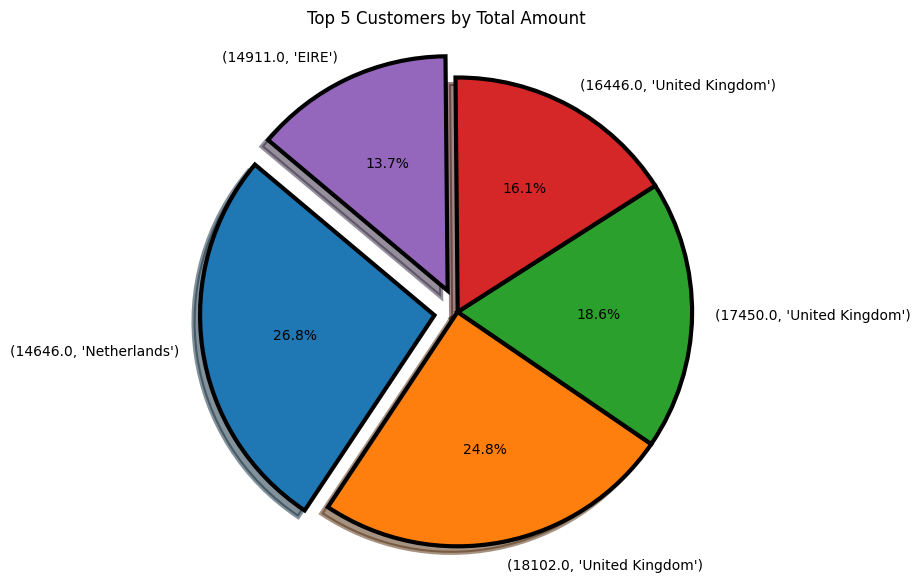

In [ ]:
# Identify the indices of the highest and lowest values
max_index = top_5_customers['TotalAmount'].idxmax()
min_index = top_5_customers['TotalAmount'].idxmin()

# Create explode list, where the highest and lowest values are offset
explode = [0.1 if customer == max_index or customer == min_index else 0 for customer in top_5_customers.index]

# Create a pie chart with exploded wedges, shadow, and custom wedge properties
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(
    top_5_customers['TotalAmount'],
    labels=top_5_customers.index,
    autopct='%1.1f%%',
    startangle=140,
    shadow=True,  # Add shadow
    explode=explode,  # Explode the highest and lowest wedges
    wedgeprops={'edgecolor': 'black', 'linewidth': 3}  # Customize wedge properties
)

# Customize the text appearance
for text in texts + autotexts:
    text.set_fontsize(10)
    text.set_color('black')

plt.title('Top 5 Customers by Total Amount')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Hasil diatas menunjukkan  top 5 CustomerID dengan TotalAmount spend terbanyak

In [ ]:
# b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa
# Extract from column 'InvoiceDate' to (Day, Hour, Month, dan WeekNumber)
df_answer['Day'] = df_answer['InvoiceDate'].dt.day_name()
df_answer['Hour'] = df_answer['InvoiceDate'].dt.hour
df_answer['Month'] = df_answer['InvoiceDate'].dt.month_name()
df_answer['WeekNumber'] = df_answer['InvoiceDate'].dt.isocalendar().week

# Group by Day and count unique CustomerID
day_counts = df_answer.groupby('Day')['CustomerID'].nunique().reset_index(name='CustomerCount')
top_day = day_counts.loc[day_counts['CustomerCount'].idxmax()]

# Group by Hour and count unique CustomerID
hour_counts = df_answer.groupby('Hour')['CustomerID'].nunique().reset_index(name='CustomerCount')
top_hour = hour_counts.loc[hour_counts['CustomerCount'].idxmax()]

# Group by Month and count unique CustomerID
month_counts = df_answer.groupby('Month')['CustomerID'].nunique().reset_index(name='CustomerCount')
top_month = month_counts.loc[month_counts['CustomerCount'].idxmax()]

# Group by WeekNumber and count unique CustomerID
week_counts = df_answer.groupby('WeekNumber')['CustomerID'].nunique().reset_index(name='CustomerCount')
top_week = week_counts.loc[week_counts['CustomerCount'].idxmax()]

# Combine results into a dataframe
results = pd.DataFrame({
    'Information': ['Day', 'Hour', 'Month', 'WeekNumber'],
    'Value': [top_day['Day'], top_hour['Hour'], top_month['Month'], top_week['WeekNumber']],
    'CustomerCount': [top_day['CustomerCount'], top_hour['CustomerCount'], top_month['CustomerCount'], top_week['CustomerCount']]
})

# Print results
print(f"Day with the most customers: {top_day['Day']} with {top_day['CustomerCount']} customers")
print(f"Hour with the most customers: {top_hour['Hour']} with {top_hour['CustomerCount']} customers")
print(f"Month with the most customers: {top_month['Month']} with {top_month['CustomerCount']} customers")
print(f"Week with the most customers: Week {top_week['WeekNumber']} with {top_week['CustomerCount']} customers\n")

# Display the results dataframe
results

Day with the most customers: Thursday with 2007 customers
Hour with the most customers: 12 with 1637 customers
Month with the most customers: November with 1664 customers
Week with the most customers: Week 48 with 745 customers



,Information,Value,CustomerCount
0,Day,Thursday,2007
1,Hour,12,1637
2,Month,November,1664
3,WeekNumber,48,745


In [ ]:
df_answer.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalAmount,Hour,WeekNumber
count,397884.000000,397884,397884.000000,397884.000000,397884.000000,397884.000000,397884.0
mean,12.988238,2011-07-10 23:41:23.511023360,3.116488,15294.423453,22.397000,12.728202,30.964361
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,0.001000,6.000000,1.0
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000,4.680000,11.000000,19.0
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000,11.800000,13.000000,34.0
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000,19.800000,14.000000,44.0
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000,20.000000,51.0
std,179.331775,NaN,22.097877,1713.141560,309.071041,2.273519,14.755843


Dari analisa bagian b, kita bisa mendapatkan informasi bahwa:


*   Hari Kamis merupakan hari Customer terbiasa untuk berbelanja dengan 2007 customers.
*   Pukul 12 Siang merupakan waktu tertinggi customers berbelanja sebanyak 1637 customers.
*   Bulan November merupakan bulan dengan peningkatan kenaikan jumlah customers berbelanja dengan 1664 Customers.
*   Week ke 48 atau Minggu akhir bulan Desember merupakan minggu dengan customers berbelanja tertinggi yaitu sebesar 745 customers



#Jawaban Question 2


### **Soal:** Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?

Ciri-ciri dari masing-masing cluster dilihat dari Recency, Frequency dan Monetary Spent.<br>
Cluster 0/Customers UK:


*   Memiliki jumlah recency, frequecy dan Monetary Spent yang jauh lebih banyak dibanding Cluster 1/Customers NonUK atau dengan kata lain Customer UK lebih sering berbelanja dengan nilai nominal belanja kecil. Dapat dilihat dari Recency, Frequency dan MonetarySpent
*   Cluster 1/NonUK lebih jarang berbelanja, tetapi sekali berbelanja dengan nominal belanja yang besar/Bulk order.



**A.** Promo yang dapat dicoba untuk diberikan kepada **Cluster 0/Customer UK**, yaitu dengan memberikan diskon/cashback dengan minimum pembelian untuk meningkatkan jumlah transaksi. Atau, dengan mendorong Seller dengan membuat promo bundling product(Buy More Save More)untuk meningkatkan jumlah keranjang per transaksi. Bisa juga diberikan pancingan voucher diskon untuk belanja lebih banyak, diskon lebih besar<br><br>
**B.** Promo untuk **Cluster 1/Costumer NonUK**, karena terbiasa berbelanja dengan nilai nominal besar, bisa diberikan voucher diskon/cashback dengan nominal pembelian banyak, mendapat potongan diskon lebih banyak. Atau, bisa dipancing juga untuk memulai transaksi dengan nilai nominal kecil dengan diberikan voucher diskon dengan minimal pembelian lebih sedikit.<br><br>
**C.** Beri stimulus pada masing-masing cluster, jika sampai pada tahap tertentu maka akan naik level. Bisa lebih banyak voucher/nilai voucher/dapat gift.





#Jawaban Question 3

### **Soal:** Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

In [ ]:
# Buat filter variabel untuk mengeluarkan hasil UK dan atau United Kingdom, tanda ~ artinya NOT atau untuk membalikkan hasil dari kondisi
df_answer_NonUK = df_answer[~df_answer['Country'].isin(['UK', 'United Kingdom'])]

# Grouping berdasarkan CustomerID dan Country dan menampilkan TotalAmount spend dari Customers NonUK
customer_order = df_answer_NonUK.groupby(['CustomerID', 'Country']).agg({'TotalAmount': 'sum'}).sort_values(by='TotalAmount', ascending=False).reset_index()

customer_order.head(10)

,CustomerID,Country,TotalAmount
0,14646.0,Netherlands,280206.02
1,14911.0,EIRE,143825.06
2,12415.0,Australia,124914.53
3,14156.0,EIRE,117379.63
4,17404.0,Sweden,31906.82
5,12753.0,Japan,21429.39
6,12744.0,Singapore,21279.29
7,12471.0,Germany,19824.05
8,12731.0,France,18895.91
9,12678.0,France,17628.46


In [ ]:
# Grouping berdasarkan Country dan menampilkan TotalAmount spend dari Customers NonUK
customer_order_country = df_answer_NonUK.groupby('Country').agg({'TotalAmount': 'sum'}).sort_values(by='TotalAmount', ascending=False).reset_index()

customer_order_country.head(10)

,Country,TotalAmount
0,Netherlands,285446.34
1,EIRE,265545.90
2,Germany,228867.14
3,France,209024.05
4,Australia,138521.31
5,Spain,61577.11
6,Switzerland,56443.95
7,Belgium,41196.34
8,Sweden,38378.33
9,Japan,37416.37


In [ ]:
# Grouping berdasarkan Country dan menampilkan TotalAmount spend dari Customers NonUK
customer_order_descrips = df_answer_NonUK.groupby('Description').agg({'Quantity': 'sum'}).sort_values(by='Quantity', ascending=False).reset_index()

customer_order_descrips.head(10)

,Description,Quantity
0,RABBIT NIGHT LIGHT,15437
1,MINI PAINT SET VINTAGE,12493
2,PACK OF 72 RETROSPOT CAKE CASES,11228
3,SPACEBOY LUNCH BOX,8364
4,DOLLY GIRL LUNCH BOX,7344
5,RED TOADSTOOL LED NIGHT LIGHT,6735
6,ROUND SNACK BOXES SET OF4 WOODLAND,6709
7,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5233
8,PLASTERS IN TIN WOODLAND ANIMALS,5136
9,PLASTERS IN TIN SPACEBOY,4935


Berdasarkan hasil output dari analisis karakteristik utama dari masing-masing cluster non UK, berikut adalah beberapa kesimpulan yang dapat diambil:

*   Negara selain UK yang memiliki jumlah TotalAmount Customers Spend yaitu 5 Countries yaitu( Netherlands, EIRE(Republik Irlandia), Germany, France dan Australia)
*   Sisa Negara lainnya tidak terlalu memiliki TotalAmount yang signifikan

*   3 Produk teratas yang banyak dibeli oleh customers NonUK yaitu (RABBIT NIGHT LIGHT, MINI PAINT SET VINTAGE, PACK OF 72 RETROSPOT CAKE CASES)
*   Jika melihat dari CustomerID NonUK, Customers dengan CustomerID berikut memiliki TotalAmount yang tinggi:

    1.   14646	Netherlands TotalAmount 280206.02
    2.   14911	EIRE	      Total Amount 143825.06
    3.   12415	Australia	  Total Amount 124914.53
    4.   14156	EIRE	      Total Amount 117379.63


